In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("trip_count_by_zone_sql").getOrCreate()

24/12/18 11:00:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
import os
trip_files = '/home/lab01/src/data/trip/*'
zone_file = '/home/lab01/src/data/taxi+_zone_lookup.csv'

# CSV 파일 읽기
trips_df = spark.read.csv(trip_files, inferSchema=True, header=True)
zone_df = spark.read.csv(zone_file, inferSchema=True, header=True)

In [6]:
zone_df.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [7]:
trips_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [8]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [9]:
query = """
SELECT 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM 
    trips t
    LEFT JOIN 
        zone pz
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone dz
    ON 
        t.DOLocationID = dz.LocationID
"""
comb_df = spark.sql(query)

# 새로운 TempView에 담는다.
comb_df.createOrReplaceTempView("comb_df")
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [10]:
from pyspark.sql.functions import *
# 기초 통계 확인
comb_df.describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+-----------------+-------------------+--------------------+--------------------+
|summary|          vendor_id|       pickup_time|      dropoff_time|   passenger_count|    trip_distance|       fare_amount|       tip_amount|       tolls_amount|     total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+-----------------+-------------------+--------------------+--------------------+
|  count|           14166672|          15000700|          15000700|          14166672|         15000700|          15000700|         15000700|           15000700|         15000700|           14166672|            15000700|            15000700|
|   mean| 1.6872103059914143|14.

In [11]:
# 각 열 대해 결측치 개수 계산
missing_data = comb_df.select([(col(c).isNull()).cast("int").alias(c) for c in comb_df.columns])
missing_data.show()

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-----------+------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|pickup_zone|dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-----------+------------+
|        0|          0|           0|          0|           0|              0|            0|          0|         0|           0|           0|           0|          0|           0|
|        0|          0|           0|          0|           0|              0|            0|          0|         0|           0|           0|           0|          0|           0|
|        0|          0|           0|          0|           0|              0|            0|          0|  

In [12]:
# 요금의 요약 확인
comb_df.select("total_amount").describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205708744|
| stddev|145.7442452805979|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



금액이 최솟값이 음수로 측정되는 경우가 생김

In [13]:
# 이동거리
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000700|
|   mean|6.628629402627818|
| stddev|671.7293482115828|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [14]:
# 승객 수
comb_df.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166672|
|   mean|1.4253783104458126|
| stddev|  1.04432704905968|
|    min|                 0|
|    max|                 9|
+-------+------------------+



In [15]:
query = '''
SELECT pickup_date, pickup_time
FROM comb_df
WHERE pickup_date < '2020-12-31' OR pickup_date > '2021-07-31'
'''
spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2021-08-09|         15|
| 2021-08-09|         15|
| 2021-08-09|         16|
| 2021-08-31|          0|
+-----------+-----------+
only showing top 20 rows



In [16]:
# 월 단위로 데이터를 그룹핑하여 확인한다.
query = """
SELECT
     DATE_TRUNC('MM', c.pickup_date) AS month,
     COUNT(*) AS trips
FROM
    comb_df c
GROUP BY
    month
ORDER BY
    month desc
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821430|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371688|
|2021-01-01 00:00:00|1369749|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



2021년 1~7월 데이터이기 때문에 불필요한 날짜는 삭제할 필요가 있다.

In [17]:
# 전처리 코드
query = """
SELECT
    *
FROM 
    comb_df c
WHERE
    c.total_amount < 5000
    AND c.total_amount > 0
    AND c.trip_distance < 100
    AND c.passenger_count < 5
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
"""
clean_df = spark.sql(query)
clean_df.createOrReplaceTempView("clean_df")

In [18]:
clean_df.describe().show(5)

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+
|summary|         vendor_id|       pickup_time|      dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|      tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+
|  count|          13498910|          13498910|          13498910|          13498910|          13498910|          13498910|          13498910|          13498910|          13498910|           13498910|            13498910|            13498910|
|   mean|1.6724241438753202|

In [19]:
clean_df.select("dropoff_time", "passenger_count", "trip_distance", 'fare_amount', 'tip_amount').describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|      dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|          13498910|          13498910|          13498910|          13498910|          13498910|
|   mean|14.287686190959121|1.2508243998959916| 2.843456607977929|12.178530447272134|2.1886030879535725|
| stddev| 5.194758200312504| 0.635395541280105|3.6332822258138178|11.024886066692739| 2.580128088909473|
|    min|                 0|                 0|               0.0|              -0.8|               0.0|
|    max|                23|                 4|             99.96|            4969.0|             700.0|
+-------+------------------+------------------+------------------+------------------+------------------+



# 시간대별 탑승 분석
## 목표: 특정 시간대에 얼마나 많은 택시 승차가 발생하는지 분석.
## 탑승 시간 (pickup_time)에 따른 택시 승차 횟수를 그래프로 표시.
그래프는 출근 시간(7시9시)과 퇴근 시간(17시19시)에 택시 승차 수요가 급증하는 경향을 보입니다.<br>
반면, 심야 시간대와 새벽 시간대에는 승차 횟수가 적어, 택시의 수요가 낮다는 것을 알 수 있습니다.<br>
이러한 분석은 택시 회사나 교통 관리자가 시간대별로 운행 스케줄을 최적화하는 데 도움이 될 수 있습니다.<br>

In [24]:
query = """
SELECT pickup_time, COUNT(*) AS trip_count
FROM clean_df
GROUP BY pickup_time
ORDER BY pickup_time;
"""
# spark.sql(query).show()

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# SQL 쿼리 실행 결과를 query_result에 저장
query_result = spark.sql(query)

# 결과를 Pandas DataFrame으로 변환
df = query_result.toPandas()

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(df['pickup_time'], df['trip_count'], marker='o', linestyle='-', color='b')
plt.title('Taxi Pickup Pattern by Hour', fontsize=16)
plt.xlabel('Pickup Time (Hour)', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# 그래프 출력
plt.show()

KeyError: 'pickup_time'

<Figure size 1000x600 with 0 Axes>

# 승객 수에 따른 여행 통계
## 목표: 승객 수별로 여행의 특성을 분석 (예: 총 금액(avg_total_amount), 거리(avg_trip_distance), 팁 등).
## 승객 수에 따른 평균 여행 거리, 총 금액 등을 비교하는 그래프.
승객 수가 증가함에 따라 평균 이동 거리와 평균 총 금액이 모두 증가하지만, 총 금액의 증가율이 더 크다는 점을 확인할 수 있습니다.<br>
이는 승객 수가 많을수록 더 긴 거리로 이동하거나 더 많은 비용이 발생하는 경향이 있음을 나타냅니다.


In [29]:
!pip install seaborn

In [26]:
query = """
SELECT passenger_count, AVG(trip_distance) AS avg_trip_distance, AVG(total_amount) AS avg_total_amount
FROM clean_df
GROUP BY passenger_count
ORDER BY passenger_count;
"""
# spark.sql(query).show()

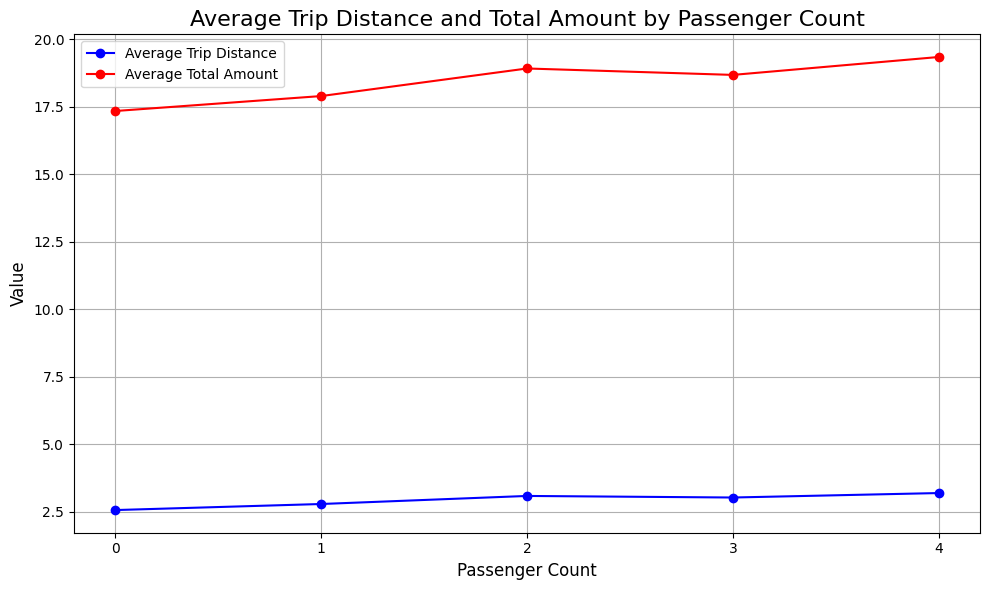

In [27]:
result = spark.sql(query)

df = result.toPandas()

plt.figure(figsize=(10, 6))

# 평균 이동 거리 (avg_trip_distance)
plt.plot(df['passenger_count'], df['avg_trip_distance'], marker='o', linestyle='-', color='b', label='Average Trip Distance')

# 평균 총 금액 (avg_total_amount)
plt.plot(df['passenger_count'], df['avg_total_amount'], marker='o', linestyle='-', color='r', label='Average Total Amount')

# 그래프 제목 및 레이블
plt.title('Average Trip Distance and Total Amount by Passenger Count', fontsize=16)
plt.xlabel('Passenger Count', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(df['passenger_count'])  # 승객 수 값에 맞춰 x축 레이블 표시
plt.legend()

# 그래프 출력
plt.grid(True)
plt.tight_layout()
plt.show()

# 일 별 운행수
이 선 그래프를 통해, 날짜별 택시 이용량의 변화를 관찰할 수 있으며, 이를 통해 특정 날짜에 택시 이용이 급증하거나 감소하는 이유를 파악할 수 있습니다.

<Axes: xlabel='pickup_date', ylabel='trips'>

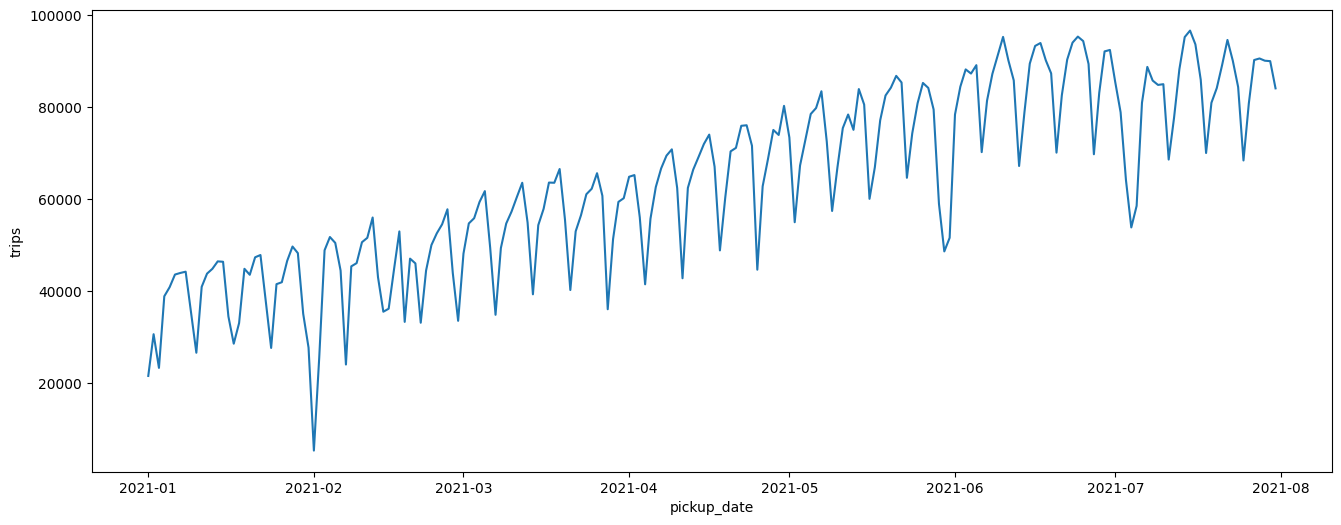

In [32]:
query = """
SELECT 
    c.pickup_date,
    COUNT(*) AS trips
FROM
    clean_df c
GROUP BY
    c.pickup_date
"""
pd_df = spark.sql(query).toPandas()

fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x="pickup_date", y="trips", data=pd_df)

# 요일 별 운행 수
주말보다 평일이 택시 운행량이 많은 것을 볼 수 잇다.

In [36]:
query = """
SELECT 
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    clean_df c
GROUP BY
    c.pickup_date,
    day_of_week
"""
pd_df2 = spark.sql(query).toPandas()

In [37]:
# 요일 별 정렬을 위해 컬럼을 하나 만든다.
data = pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
data["sort_dow"] = data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})


data.sort_values(by="sort_dow", inplace=True)
data

,day_of_week,trips,sort_dow
3,Sunday,43748.5,0
1,Monday,57165.0,1
5,Tuesday,67613.5,2
6,Wednesday,70195.5,3
4,Thursday,73011.0,4
0,Friday,74073.0,5
2,Saturday,62455.0,6


<Axes: xlabel='day_of_week', ylabel='trips'>

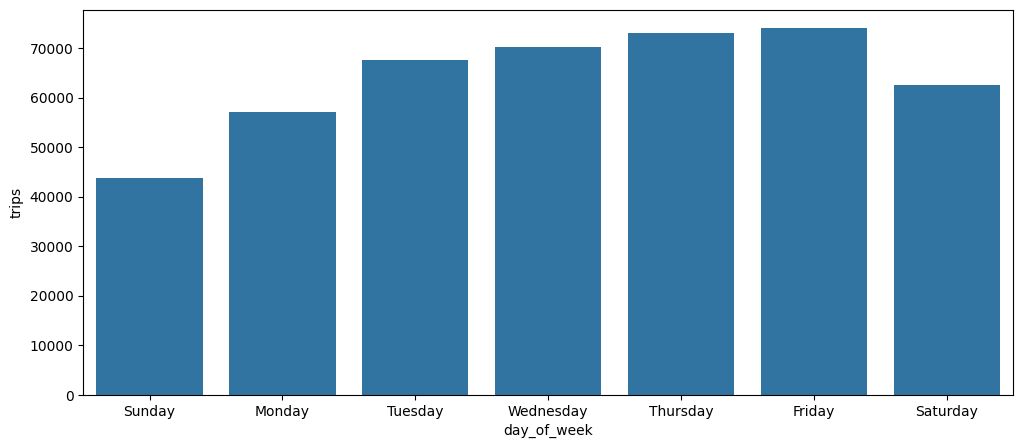

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    x="day_of_week",
    y="trips",
    data=data
)

# 결제 타입 패턴
신용 카드로 결제한게 제일 많은 것을 확인 할 수 있었다.

In [40]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",   # 계산되지 않음
    4: "Dispute",     # 분쟁이 있었음
    5: "Unknown",
    6: "Voided Trip", # 취소된 운행
}

In [41]:
def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("parse_payment_type", parse_payment_type)


24/12/18 14:54:00 WARN SimpleFunctionRegistry: The function parse_payment_type replaced a previously registered function.


<function __main__.parse_payment_type(payment_type)>

In [42]:
query = """
SELECT 
    parse_payment_type(payment_type),
    count(*) AS trips,
    MEAN(fare_amount) AS mean_fare_amount,
    STD(fare_amount) AS stdev_fare_amount
FROM
    clean_df
GROUP BY
    payment_type
"""

spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount| stdev_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10263923| 12.22907173114956|10.829240060683142|
|                       No Charge|   59144|11.978743067766809| 15.07571096506127|
|                         Unknown|       1|              17.8|              null|
|                         Dispute|   23805|12.701679479101026|14.234437019540003|
|                            Cash| 3152037| 12.01374976562773|11.525480006779633|
+--------------------------------+--------+------------------+------------------+



In [43]:
spark.stop()